In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('AccidentesAviones.csv', index_col=0)
# df.sample(5)
df.shape

(5008, 17)

I think columns are ugly named and messy, let's make some order!

In [3]:
# Rename columns
df.rename(columns={'fecha': 'date'}, inplace=True)
df.rename(columns={'HORA declarada': 'hour'}, inplace=True)
df.rename(columns={'Ruta': 'location'}, inplace=True)
df.rename(columns={'OperadOR': 'operator'}, inplace=True)
df.rename(columns={'ac_type': 'type'}, inplace=True)
df.rename(columns={'all_aboard': 'total_aboard'}, inplace=True)
df.rename(columns={'PASAJEROS A BORDO': 'passengers_aboard'}, inplace=True)
df.rename(columns={'cantidad de fallecidos': 'total_fatalities_aboard'}, inplace=True)
df.rename(columns={'ground': 'ground_fatalities'}, inplace=True)

# Order columns
df = df[['date', 'hour', 'location', 'operator', 'flight_no', 'route', 'type', 'registration', 'cn_ln', 'passengers_aboard', 'crew_aboard', \
    'total_aboard', 'passenger_fatalities', 'ground_fatalities', 'crew_fatalities', 'total_fatalities_aboard', 'summary']]

Now It is a little bit better but data is still dirty...

In [4]:
obs, feat = df.shape
print(str("Dataset consist of " + str(obs) + " observations (crashes) and " + str(feat) + " features. Features are following:"))

Dataset consist of 5008 observations (crashes) and 17 features. Features are following:


- date
- hour
- location
- operator (airline or operator of the aircraft)
- flight_no (flight number assigned by the aircraft operator)
- route (complete or partial route flown prior to the accident)
- type (aircraft type)
- registration (ICAO registration of the aircraft)
- cn/ln (construction or serial number / Line or fuselage number)
- passengers_aboard
- crew_aboard
- total_aboard
- passenger_fatalities
- ground_fatalities (people killed on the ground)
- crew_fatalities
- total_fatalities_aboard (passengers / crew)
- summary (brief summary of the case)

Replace "?" for null values and drop some colums

In [5]:
df.replace("?", None, inplace=True)

columns_to_drop=['flight_no', 'route', 'registration', 'cn_ln', 'passengers_aboard', 'crew_aboard', 'passenger_fatalities', 'ground_fatalities', 'crew_fatalities']
df.drop(columns=columns_to_drop, inplace=True)

In [6]:
# Calculating missing values in rows
# df.isnull().sum()

Drop null values and change to numerical type where suited

In [7]:
df.dropna(subset=['total_aboard'], inplace=True)
df['total_aboard'] = df['total_aboard'].astype(int)
df['total_fatalities_aboard'] = df['total_fatalities_aboard'].astype(int)

In [8]:
# Calculating missing values in rows
# df.isnull().sum()


# Let's clean the first two columns about date time

To determine whether to add a leading or trailing zero when formatting a number as a time value, you can follow these general guidelines:

If the number has three digits and the last two digits are less than 60, add a zero at the beginning. For example, "900" becomes "0900".

If the number has three digits and the last two digits are 60 or greater, add a zero at the end. For example, "175" becomes "1750".

In [9]:
# If null it is gonna be consired as happened at 00:00
df['hour'] = df['hour'].fillna('0000')

# Define a function to extract the digits from the string so values like 'c 18:00' are transformed to '1800', "c 9:15" to "915", etc.
def extract_digits(string):
    digits = re.findall(r'\d+', string)
    return ''.join(digits)

# Apply the function to the 'hour' column
df['hour'] = df['hour'].apply(extract_digits)

def format_time(hour):
    if len(hour) == 3:
        last_two_digits = int(hour[-2:])
        if last_two_digits < 60:
            return "0" + hour
        else:
            return hour + "0"
    return hour

df['hour'] = df['hour'].apply(format_time)

###  Check if "hour" column is in the desired format:

In [10]:
# Use regex pattern to check for the desired number format
pattern = r'^\d{4}$'  # Matches a 4-digit number

# Create a boolean mask for rows that do not match the pattern
mask = ~df['hour'].astype(str).str.contains(pattern)

# Apply the mask to retrieve the rows with different number format
rows_with_different_format = df[mask]

# No row returned because all rows have four digits in "hour" column. Data here is cleaned.
rows_with_different_format

,date,hour,location,operator,type,total_aboard,total_fatalities_aboard,summary


### Let's finally combine "date" and "hour" columns:

In [11]:
df[['date', 'hour']].head()

,date,hour
0,"September 17, 1908",1718
1,"September 07, 1909",0000
2,"July 12, 1912",0630
3,"August 06, 1913",0000
4,"September 09, 1913",1830


In [12]:
# Combine 'date' and 'hour' columns into a single datetime column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['hour'], format='%B %d, %Y %H%M')
df = df.drop(['date', 'hour'], axis=1)
df['datetime'].head()

0   1908-09-17 17:18:00
1   1909-09-07 00:00:00
2   1912-07-12 06:30:00
3   1913-08-06 00:00:00
4   1913-09-09 18:30:00
Name: datetime, dtype: datetime64[ns]

In [13]:
print('Date ranges from ' + str(df["datetime"].min()) + ' to ' + str(df["datetime"].max()))

Date ranges from 1908-09-17 17:18:00 to 2021-07-06 15:00:00


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4991 entries, 0 to 5007
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   location                 4986 non-null   object        
 1   operator                 4981 non-null   object        
 2   type                     4980 non-null   object        
 3   total_aboard             4991 non-null   int32         
 4   total_fatalities_aboard  4991 non-null   int32         
 5   summary                  4940 non-null   object        
 6   datetime                 4991 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int32(2), object(4)
memory usage: 272.9+ KB


# Export cleaned data

In [15]:

df.to_csv('accidents_cleaned.csv', index=False)

# ANALYSIS

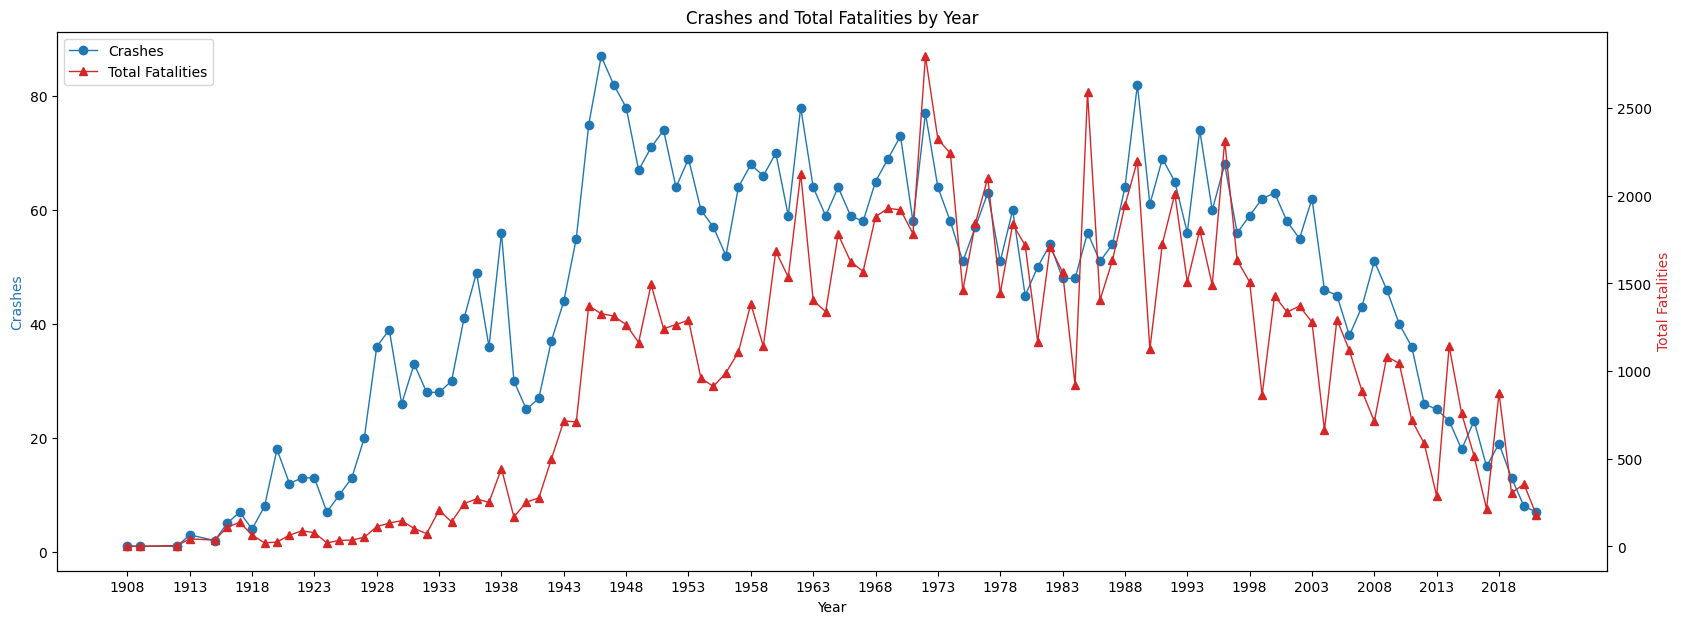

In [16]:
# Calculate crashes by year
crashes_by_year = df['datetime'].dt.year.value_counts().sort_index()

# Calculate total fatalities by year
fatalities_by_year = df.groupby(df['datetime'].dt.year)['total_fatalities_aboard'].sum()

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(20, 7))

# Plot crashes on left y-axis
ax1.plot(crashes_by_year.index, crashes_by_year.values, marker='o', linewidth=1, label='Crashes')
ax1.set_xlabel('Year')
ax1.set_ylabel('Crashes', color='tab:blue')
ax1.set_title('Crashes and Total Fatalities by Year')

# Create a second y-axis for total fatalities
ax2 = ax1.twinx()

# Plot total fatalities on right y-axis with triangle marker
ax2.plot(fatalities_by_year.index, fatalities_by_year.values, marker='^', linewidth=1, color='tab:red', label='Total Fatalities')
ax2.set_ylabel('Total Fatalities', color='tab:red')

# Combine the legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Set x-axis tick locations and labels
years = np.arange(crashes_by_year.index.min(), crashes_by_year.index.max() + 1, 5)
ax1.set_xticks(years)

plt.show()

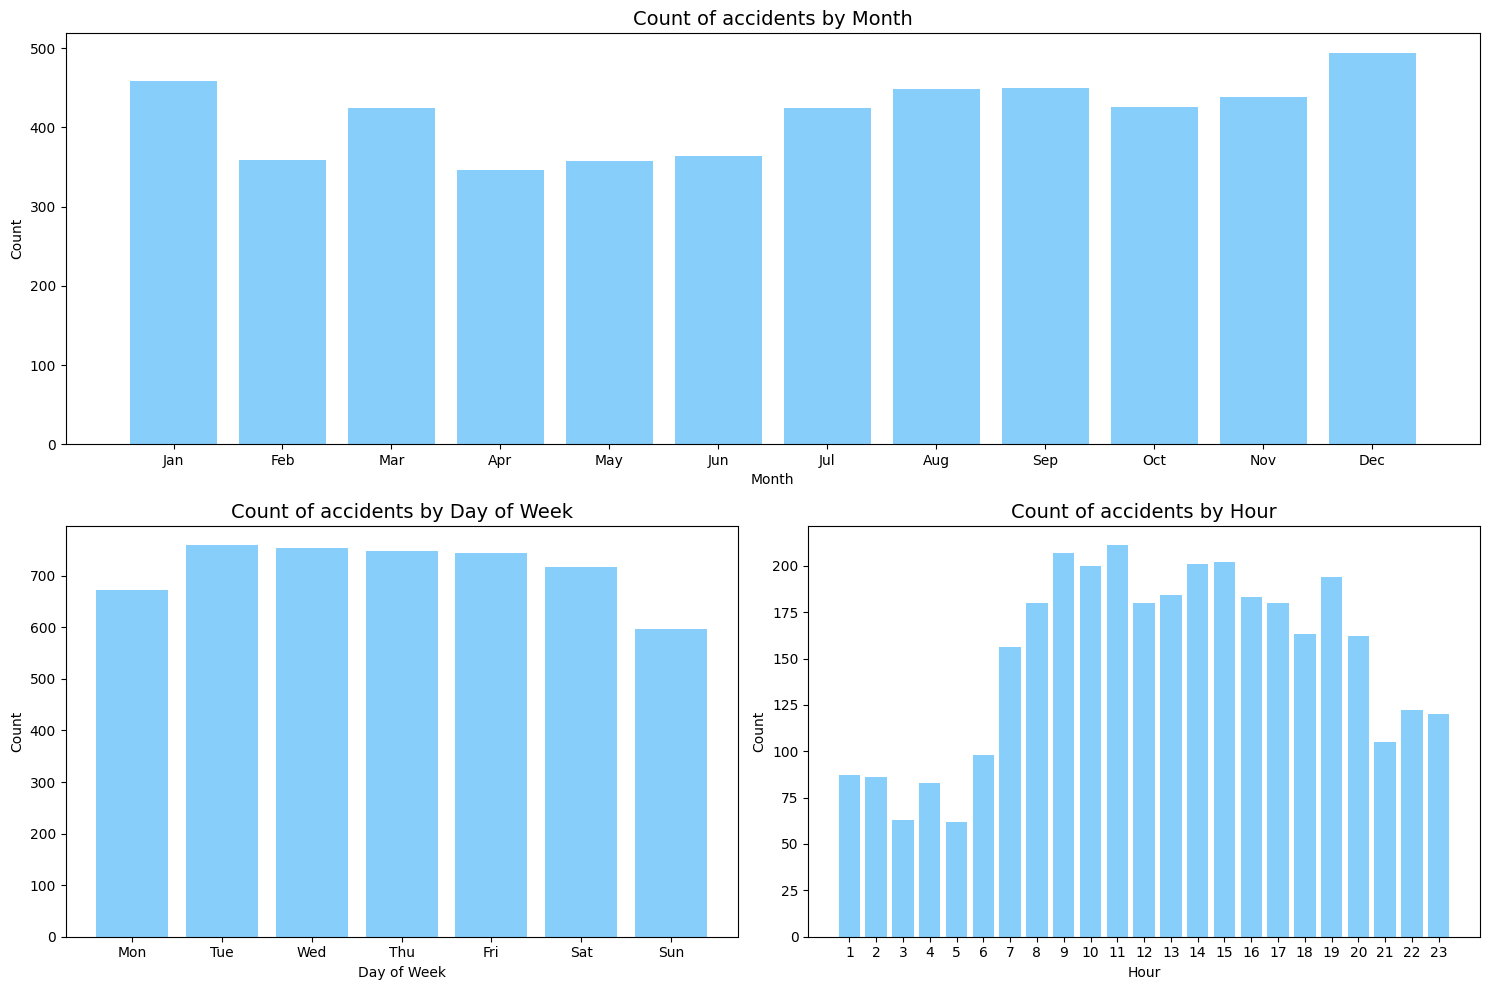

In [17]:
gs = plt.GridSpec(2, 2)
plt.figure(figsize=(15, 10))

ax = plt.subplot(gs[0, :])  # row 0, col 0
monthly_counts = df.groupby(df['datetime'].dt.month)['datetime'].count()

plt.bar(monthly_counts.index, monthly_counts.values, color='lightskyblue', linewidth=2)
plt.xticks(monthly_counts.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of accidents by Month', loc='Center', fontsize=14)

ax = plt.subplot(gs[1, 0])
weekday_counts = df.groupby(df['datetime'].dt.weekday)['datetime'].count()
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(weekday_counts.index, weekday_counts.values, color='lightskyblue', linewidth=2)
plt.xticks(weekday_counts.index, weekday_names)
plt.xlabel('Day of Week', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of accidents by Day of Week', loc='Center', fontsize=14)

ax = plt.subplot(gs[1, 1])
hourly_counts = df[df['datetime'].dt.hour != 0].groupby(df['datetime'].dt.hour)['datetime'].count()
plt.bar(hourly_counts.index, hourly_counts.values, color='lightskyblue', linewidth=2)
plt.xticks(range(1, 24))  # Specify the desired range of hours
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of accidents by Hour', loc='Center', fontsize=14)

plt.tight_layout()
plt.show()


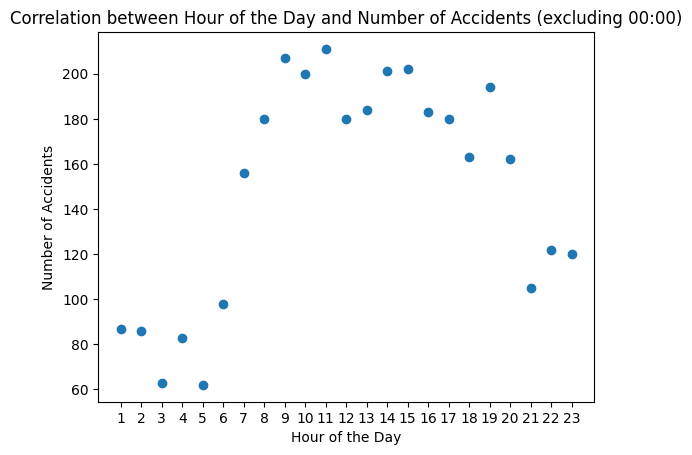

In [18]:
# Create a new column for hour
df['hour'] = df['datetime'].dt.hour

# Group the data by hour and count the number of accidents
hourly_accidents = df.groupby('hour').size()

# Exclude the hour 00:00
hourly_accidents = hourly_accidents[hourly_accidents.index != 0]

# Create scatter plot
plt.scatter(hourly_accidents.index, hourly_accidents.values)
plt.xticks(range(1, 24))  # Set x-axis ticks from 1 to 23 (excluding 00:00)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.title('Correlation between Hour of the Day and Number of Accidents (excluding 00:00)')
plt.show()

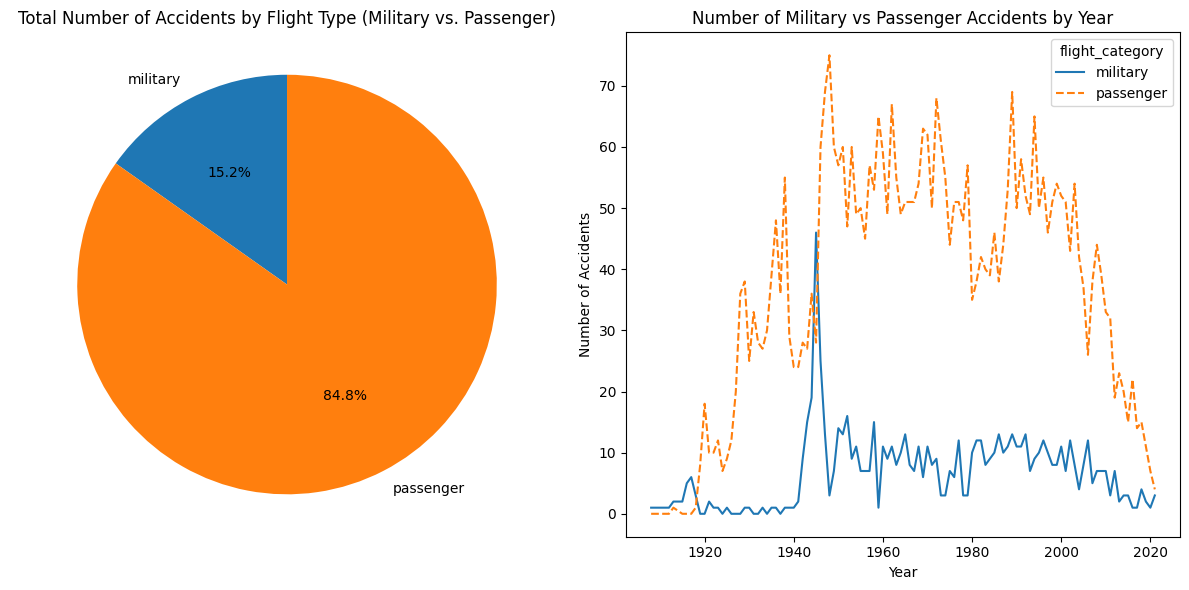

In [19]:
# Extract the required columns for analysis
df_filtered = df[['type', 'operator']]

# Filter out rows with missing values in the 'type' or 'operator' columns
df_filtered = df_filtered.dropna(subset=['type', 'operator'])

# Create a new column 'flight_category' based on the 'operator' column
df_filtered['flight_category'] = df_filtered['operator'].apply(lambda x: 'military' if 'military' in x.lower() else 'passenger')

# Group the data by flight category and type, and count the occurrences
flight_counts = df_filtered.groupby(['flight_category', 'type']).size().reset_index(name='count')

# Pivot the DataFrame to get flight categories as columns and types as rows
pivot_table = flight_counts.pivot(index='type', columns='flight_category', values='count').fillna(0)

# Plotting the circular graph
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Pie chart - Total Number of Accidents by Flight Type (Military vs. Passenger)
ax1 = axes[0]
ax1.pie(pivot_table.sum(), labels=pivot_table.columns, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax1.set_title('Total Number of Accidents by Flight Type (Military vs. Passenger)')

# Extract the required columns for analysis
df_filtered = df[['type', 'operator', 'datetime']]

# Filter out rows with missing values in the 'type', 'operator', or 'datetime' columns
df_filtered = df_filtered.dropna(subset=['type', 'operator', 'datetime'])

# Create a new column 'flight_category' based on the 'operator' column
df_filtered['flight_category'] = df_filtered['operator'].apply(lambda x: 'military' if 'military' in x.lower() else 'passenger')

# Extract the year from the 'datetime' column
df_filtered['year'] = pd.to_datetime(df_filtered['datetime']).dt.year

# Group the data by year and flight category, and count the occurrences
flight_counts = df_filtered.groupby(['year', 'flight_category']).size().reset_index(name='count')

# Pivot the DataFrame to get flight categories as columns and years as rows
pivot_table = flight_counts.pivot(index='year', columns='flight_category', values='count').fillna(0)

# Linear graph - Number of Military vs Passenger Accidents by Year
ax2 = axes[1]
pivot_table.plot(kind='line', ax=ax2, style=['-', '--'])

ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Accidents')
ax2.set_title('Number of Military vs Passenger Accidents by Year')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

plt.tight_layout()
plt.show()

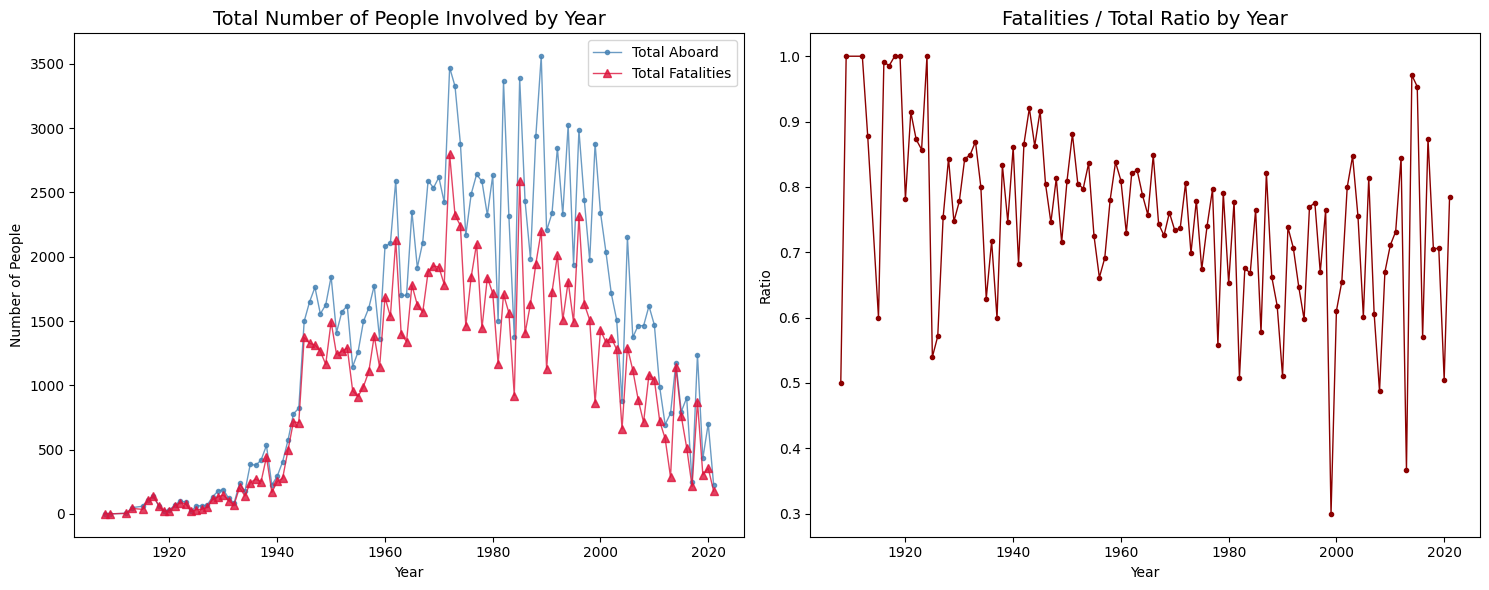

In [20]:
# Create Fatalities DataFrame
Fatalities = df.groupby(df['datetime'].dt.year)[['total_aboard', 'total_fatalities_aboard']].sum()
# Create Proportion column
Fatalities['Proportion'] = Fatalities['total_fatalities_aboard'] / Fatalities['total_aboard']

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(Fatalities.index, 'total_aboard', data=Fatalities, marker=".", color="steelblue", alpha=0.8, linewidth=1)
plt.plot(Fatalities.index, 'total_fatalities_aboard', data=Fatalities, color="crimson", marker="^", alpha=0.8, linewidth=1)
plt.legend(['Total Aboard', 'Total Fatalities'], fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of People', fontsize=10)
plt.title('Total Number of People Involved by Year', loc='Center', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(Fatalities.index, 'Proportion', data=Fatalities, marker=".", color='darkred', linewidth=1)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Ratio', fontsize=10)
plt.title('Fatalities / Total Ratio by Year', loc='Center', fontsize=14)

plt.tight_layout()
plt.show()

# Total flights data cleaning

In [21]:
# Read the CSV file into a DataFrame (data from https://data.worldbank.org/indicator/IS.AIR.DPRT)
Totals = pd.read_csv('total_flights.csv')
# Randomly sample 5 rows from the DataFrame
# Uncomment the following line if you want to see a sample of 5 rows
# Totals.sample(5)

In [22]:
columns_to_drop = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '2020', '2021', '2022','Unnamed: 67']
Totals = Totals.drop(columns_to_drop, axis = 1)
# Totals.info()
# Totals.sample(5)

In [23]:
# Replace any null values in the DataFrame with 0
Totals = Totals.replace(np.nan, 0)
# Sum the values in each column and create a new DataFrame with the sums
Totals = pd.DataFrame(Totals.sum())
# Set the index name of the DataFrame as 'Year'
Totals.index.name = 'Year'
# Name the column of the new DataFrame as 'Sum'
Totals.columns = ['Sum']
Totals.head()

,Sum
Year,
1970,57192900.0
1971,57492000.0
1972,48265300.0
1973,59114800.0
1974,64818500.0


In [24]:
# Reset the index of the 'Fatalities' DataFrame
Fatalities = Fatalities.reset_index()
# Convert the 'datetime' column of 'Fatalities' to string type
Fatalities['datetime'] = Fatalities['datetime'].astype(str)
# Set the index of 'Fatalities' DataFrame as the 'datetime' column
Fatalities.index = Fatalities['datetime']
# Remove the 'datetime' column from 'Fatalities' DataFrame
del Fatalities['datetime']
# Slice the 'Fatalities' DataFrame from '1970' to '2021'
Fatalities = Fatalities['1970':'2021']
# Keep only the 'total_fatalities_aboard' column in 'Fatalities' DataFrame
Fatalities = Fatalities[['total_fatalities_aboard']]
# Concatenate 'Totals' and 'Fatalities' DataFrames along the columns
Totals = pd.concat([Totals, Fatalities], axis=1)
# Calculate the ratio of 'total_fatalities_aboard' to 'Sum' and store it in a new column 'Ratio'
Totals['Ratio'] = Totals['total_fatalities_aboard'] / Totals['Sum'] * 100
Totals.head()

,Sum,total_fatalities_aboard,Ratio
1970,57192900.0,1920,0.003357
1971,57492000.0,1784,0.003103
1972,48265300.0,2796,0.005793
1973,59114800.0,2323,0.003930
1974,64818500.0,2242,0.003459


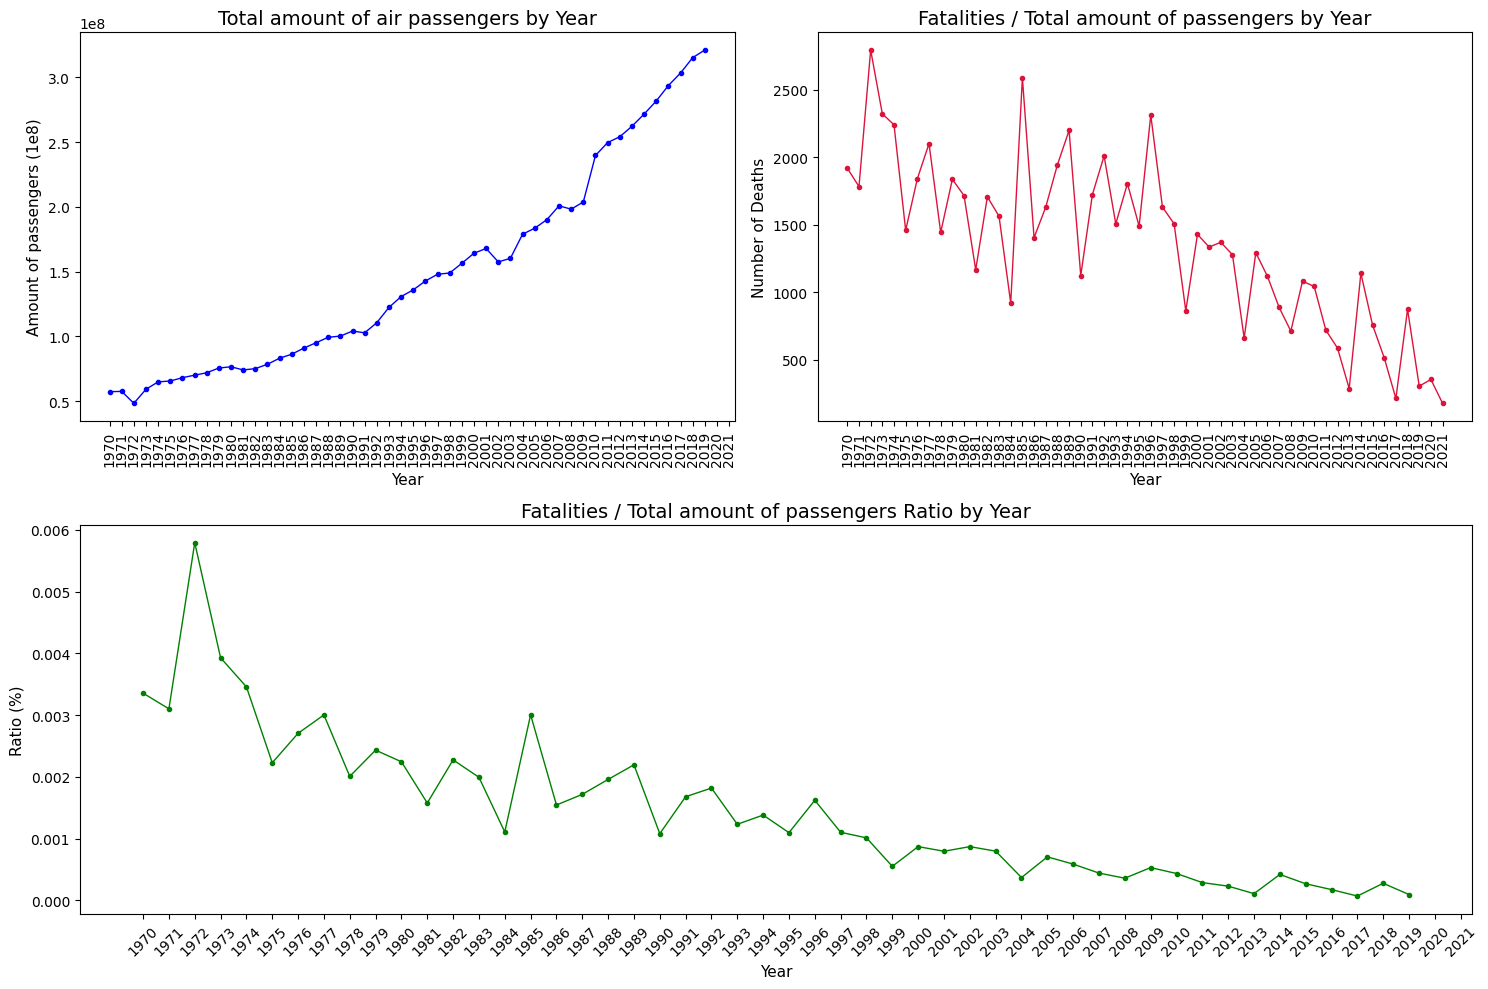

In [25]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 2)
pl.figure(figsize=(15, 10))

ax = pl.subplot(gs[0, 0]) 
pl.plot(Totals.index, 'Sum', data=Totals, marker=".", color='blue', linewidth=1)
pl.xlabel('Year', fontsize=11)
pl.ylabel('Amount of passengers (1e8)', fontsize=11)
pl.title('Total amount of air passengers by Year', loc='Center', fontsize=14)
pl.xticks(rotation=90)

ax = pl.subplot(gs[0, 1]) 
pl.plot(Fatalities.index, 'total_fatalities_aboard', data=Fatalities, color='crimson', marker=".", linewidth=1)
pl.xlabel('Year', fontsize=11)
pl.ylabel('Number of Deaths', fontsize=11)
pl.title('Fatalities / Total amount of passengers by Year', loc='Center', fontsize=14)
pl.xticks(rotation=90)

ax = pl.subplot(gs[1, :]) 
pl.plot(Totals.index, 'Ratio', data=Totals, color='green', marker=".", linewidth=1)
pl.xlabel('Year', fontsize=11)
pl.ylabel('Ratio (%)', fontsize=11)
pl.title('Fatalities / Total amount of passengers Ratio by Year', loc='Center', fontsize=14)
pl.xticks(rotation=45)
pl.tight_layout()
pl.show()

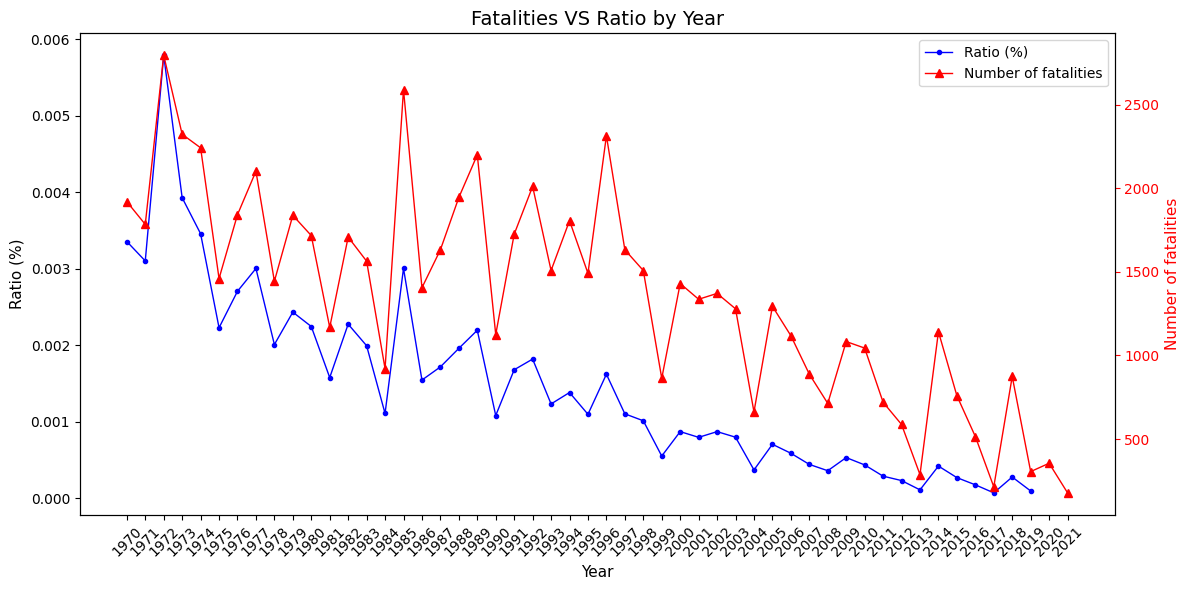

In [26]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.subplots()
ax1.plot(Totals.index, Totals['Ratio'], color='blue', marker=".", linewidth=1, label='Ratio (%)')
ax1.set_xlabel('Year', fontsize=11)
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)
ax1.set_ylabel('Ratio (%)', fontsize=11)
ax1.tick_params('y')

ax2 = ax1.twinx()
ax2.plot(Fatalities.index, Fatalities['total_fatalities_aboard'], color='red', marker="^", linewidth=1, label='Number of fatalities')
ax2.set_ylabel('Number of fatalities', color='red', fontsize=11)
ax2.tick_params('y', colors='red')

plt.title('Fatalities VS Ratio by Year', loc='Center', fontsize=14)
fig.tight_layout()

# Display legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()


# Operators Analysis

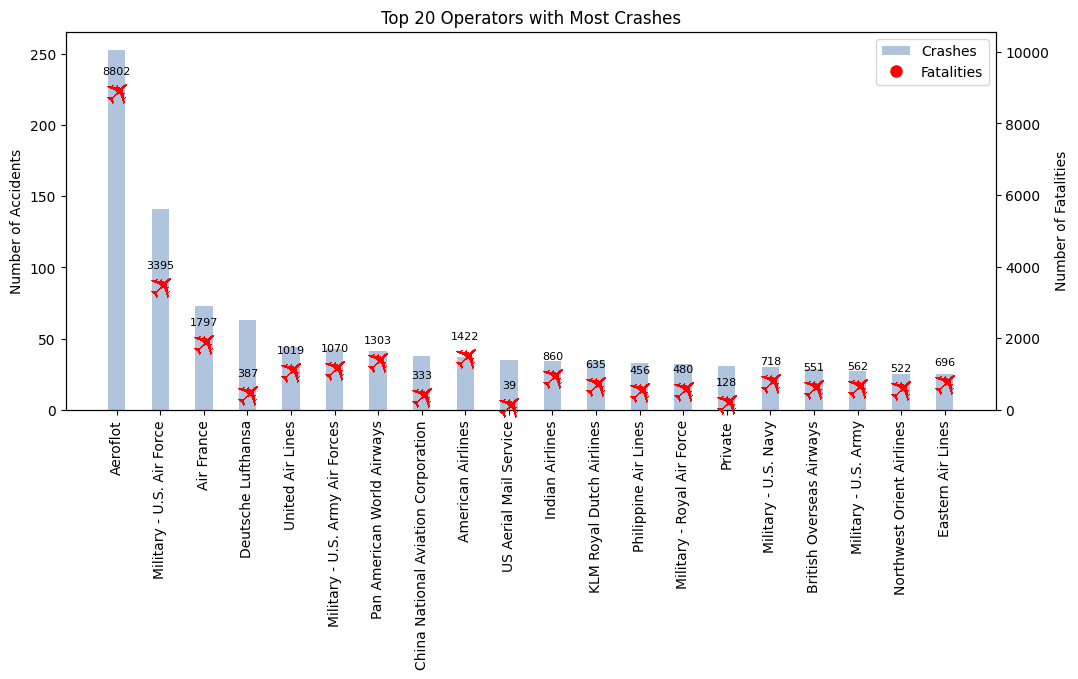

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Calculate the amount of crashes and fatalities by operator
operator_counts = df['operator'].value_counts()
fatalities_by_operator = df.groupby('operator')['total_fatalities_aboard'].sum()

# Select the top 20 operators with the most crashes
top_20_operators = operator_counts.head(20)
top_20_fatalities = fatalities_by_operator.loc[top_20_operators.index]

# Get the unique operators and their corresponding indices
operators = top_20_operators.index
indices = np.arange(len(operators))

# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the bar for crashes on the left y-axis with a lighter color
ax1.bar(indices, top_20_operators.values, width=0.4, align='center', color='lightsteelblue', label='Crashes')
ax1.set_ylabel('Number of Accidents')

# Create a twin y-axis for fatalities
ax2 = ax1.twinx()

# Define the custom marker image for fatalities
marker_path = 'plane-icon.png'
marker_image = plt.imread(marker_path)
marker_size = 20

# Plot the custom marker for fatalities on the right y-axis
for i, value in enumerate(top_20_fatalities.values):
    marker = OffsetImage(marker_image, zoom=0.015)
    xy = (indices[i], value)
    ab = AnnotationBbox(marker, xy, xycoords='data', frameon=False)
    ax2.add_artist(ab)
    
    # Add a label for the icon (positioned slightly higher)
    ax2.text(xy[0], xy[1]+500, str(value), ha='center', va='bottom', fontsize=8)

# Set the y-axis limits for fatalities to accommodate the custom marker
ax2.set_ylim(0, top_20_fatalities.max() * 1.2)

# Set the y-axis label for fatalities
ax2.set_ylabel('Number of Fatalities')

# Set the x-axis ticks and labels
ax1.set_xticks(indices)
ax1.set_xticklabels(operators, rotation=90)

# Set the title
ax1.set_title('Top 20 Operators with Most Crashes')

# Combine the legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Create a custom legend for the icon
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Fatalities')]
ax2.legend(lines + lines2 + legend_elements, labels + labels2 + ['Fatalities'], loc='upper right')

# Adjust the spacing between bars on the x-axis
plt.subplots_adjust(bottom=0.25)

# Display the graph
plt.show()


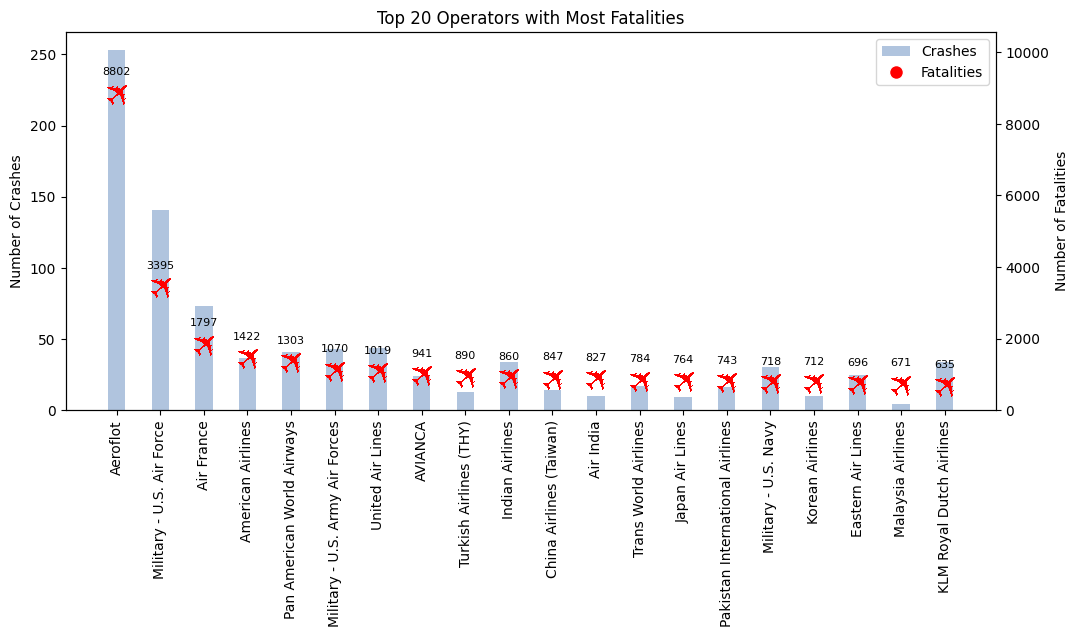

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Calculate the amount of crashes and fatalities by operator
operator_counts = df['operator'].value_counts()
fatalities_by_operator = df.groupby('operator')['total_fatalities_aboard'].sum()

# Select the top 20 operators with the most fatalities
top_20_fatalities = fatalities_by_operator.nlargest(20)
top_20_operators = top_20_fatalities.index

# Get the unique operators and their corresponding indices
operators = top_20_operators
indices = np.arange(len(operators))

# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the bar for crashes on the left y-axis with a lighter color
ax1.bar(indices, operator_counts.loc[top_20_operators], width=0.4, align='center', color='lightsteelblue', label='Crashes')
ax1.set_ylabel('Number of Crashes')

# Create a twin y-axis for fatalities
ax2 = ax1.twinx()

# Define the custom marker image for fatalities
marker_path = 'plane-icon.png'
marker_image = plt.imread(marker_path)
marker_size = 20

# Plot the custom marker for fatalities on the right y-axis
for i, value in enumerate(top_20_fatalities.values):
    marker = OffsetImage(marker_image, zoom=0.015)
    xy = (indices[i], value)
    ab = AnnotationBbox(marker, xy, xycoords='data', frameon=False)
    ax2.add_artist(ab)
    
    # Add a label for the icon (positioned slightly higher)
    ax2.text(xy[0], xy[1]+500, str(value), ha='center', va='bottom', fontsize=8)

# Set the y-axis limits for fatalities to accommodate the custom marker
ax2.set_ylim(0, top_20_fatalities.max() * 1.2)

# Set the y-axis label for fatalities
ax2.set_ylabel('Number of Fatalities')

# Set the x-axis ticks and labels
ax1.set_xticks(indices)
ax1.set_xticklabels(operators, rotation=90)

# Set the title
ax1.set_title('Top 20 Operators with Most Fatalities')

# Combine the legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Create a custom legend for the icon
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Fatalities')]
ax2.legend(lines + lines2 + legend_elements, labels + labels2 + ['Fatalities'], loc='upper right')

# Adjust the spacing between bars on the x-axis
plt.subplots_adjust(bottom=0.25)

# Display the graph
plt.show()


# Type Analysis

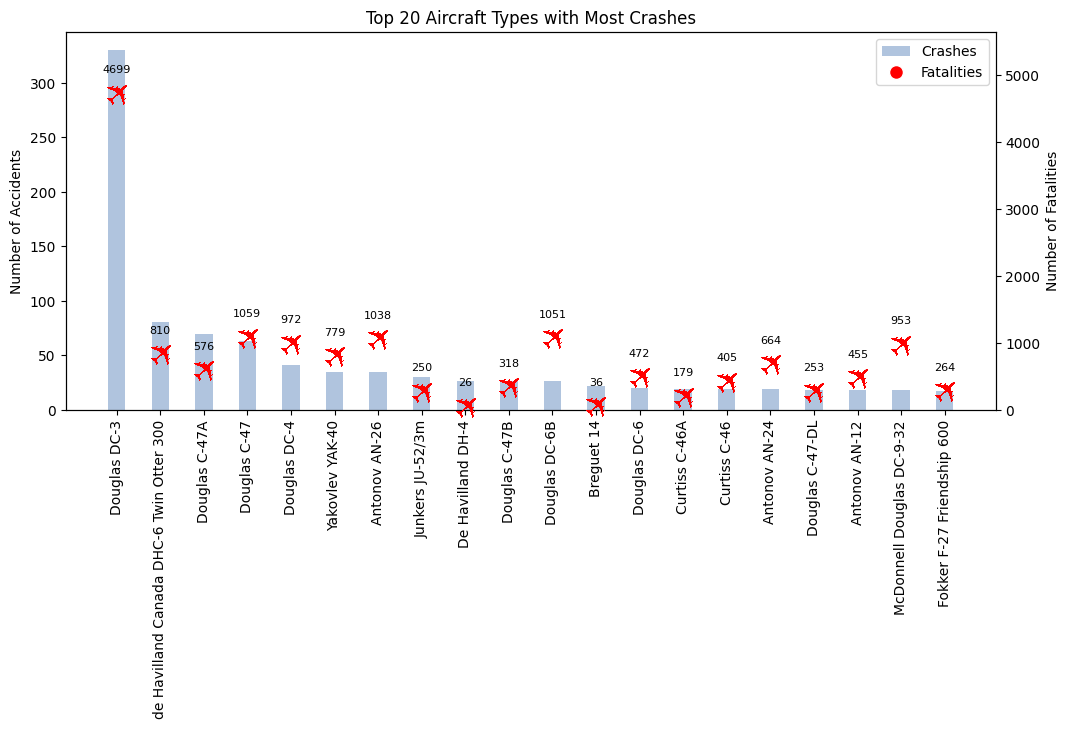

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Calculate the amount of crashes and fatalities by aircraft type
type_counts = df['type'].value_counts()
fatalities_by_type = df.groupby('type')['total_fatalities_aboard'].sum()

# Select the top 20 aircraft types with the most crashes
top_20_types = type_counts.head(20)
top_20_fatalities = fatalities_by_type.loc[top_20_types.index]

# Get the unique aircraft types and their corresponding indices
types = top_20_types.index
indices = np.arange(len(types))

# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the bar for crashes on the left y-axis with a lighter color
ax1.bar(indices, top_20_types.values, width=0.4, align='center', color='lightsteelblue', label='Crashes')
ax1.set_ylabel('Number of Accidents')

# Create a twin y-axis for fatalities
ax2 = ax1.twinx()

# Define the custom marker image for fatalities
marker_path = 'plane-icon.png'
marker_image = plt.imread(marker_path)
marker_size = 20

# Plot the custom marker for fatalities on the right y-axis
for i, value in enumerate(top_20_fatalities.values):
    marker = OffsetImage(marker_image, zoom=0.015)
    xy = (indices[i], value)
    ab = AnnotationBbox(marker, xy, xycoords='data', frameon=False)
    ax2.add_artist(ab)
    
    # Add a label for the icon (positioned slightly higher)
    ax2.text(xy[0], xy[1]+300, str(value), ha='center', va='bottom', fontsize=8)

# Set the y-axis limits for fatalities to accommodate the custom marker
ax2.set_ylim(0, top_20_fatalities.max() * 1.2)

# Set the y-axis label for fatalities
ax2.set_ylabel('Number of Fatalities')

# Set the x-axis ticks and labels
ax1.set_xticks(indices)
ax1.set_xticklabels(types, rotation=90)

# Set the title
ax1.set_title('Top 20 Aircraft Types with Most Crashes')

# Combine the legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Create a custom legend for the icon
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Fatalities')]
ax2.legend(lines + lines2 + legend_elements, labels + labels2 + ['Fatalities'], loc='upper right')

# Adjust the spacing between bars on the x-axis
plt.subplots_adjust(bottom=0.25)

# Display the graph
plt.show()


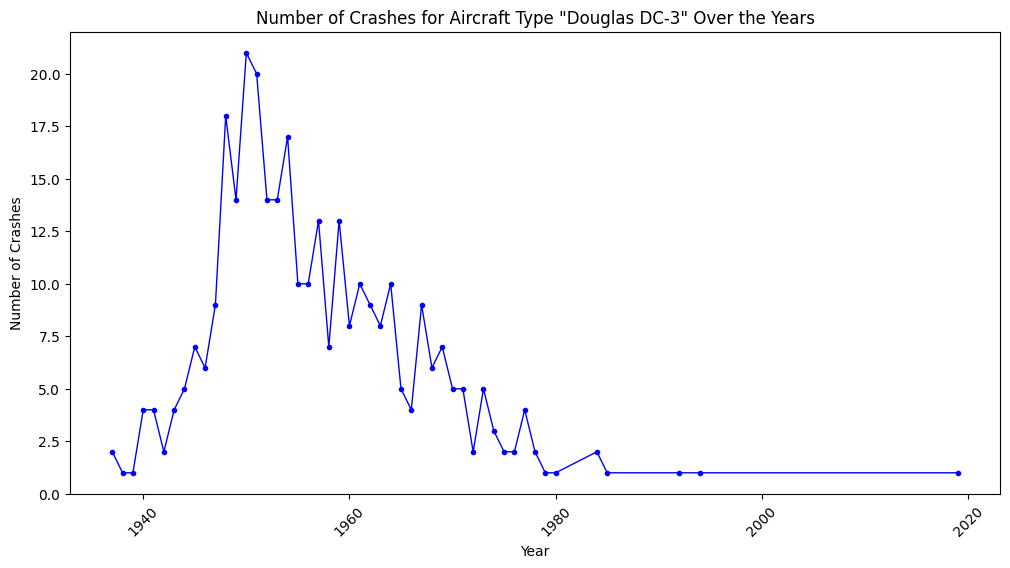

In [30]:
# Select the aircraft type with the most crashes
most_common_type = type_counts.idxmax()

# Filter the DataFrame for the selected aircraft type
type_data = df[df['type'] == most_common_type].copy()

# Extract the year from the datetime column
type_data['year'] = type_data['datetime'].dt.year

# Group the data by year and calculate the count of crashes for each year
crashes_by_year = type_data.groupby('year').size()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the number of crashes over the years
ax.plot(crashes_by_year.index, crashes_by_year.values, color='blue', marker=".", linewidth=1)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Crashes')
ax.set_title(f'Number of Crashes for Aircraft Type "{most_common_type}" Over the Years')

# Rotate the x-axis labels for better readability
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)

# Display the plot
plt.show()


In [31]:
Totals.head()

,Sum,total_fatalities_aboard,Ratio
1970,57192900.0,1920,0.003357
1971,57492000.0,1784,0.003103
1972,48265300.0,2796,0.005793
1973,59114800.0,2323,0.003930
1974,64818500.0,2242,0.003459


In [32]:
# Export the DataFrame to CSV
Totals.to_csv('total_passengers_worldbank.csv', index=True)
